# Predicting creditcard fraud (unbalanced datasets)

Objectives:
- Download the dataset and train a logistic regression model. 
- Build the confusion matrix and write the code to calculate all the metrics. 
- Try to solve the imbalance with the two techniques mentioned.

Dataset source:
https://www.kaggle.com/mlg-ulb/creditcardfraud/home?source=post_page---------------------------

## Dataset descrption (from kaggle)
The datasets contains transactions made by credit cards in September 2013 by european cardholders. This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.

It contains only numerical input variables which are the result of a PCA transformation. Unfortunately, due to confidentiality issues, we cannot provide the original features and more background information about the data. Features V1, V2, ... V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature 'Amount' is the transaction Amount, this feature can be used for example-dependant cost-senstive learning. Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.

In [24]:
# load packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('dark')
%matplotlib inline

from sklearn.model_selection import train_test_split, KFold, cross_val_predict
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
from imblearn.over_sampling import SMOTE

In [3]:
# load the dataset
data = pd.read_csv('./data/creditcard.csv')

In [4]:
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [5]:
data.shape

(284807, 31)

## Inital Investigation

In [6]:
# view the distribution
no_fraud, fraud = data['Class'].value_counts()

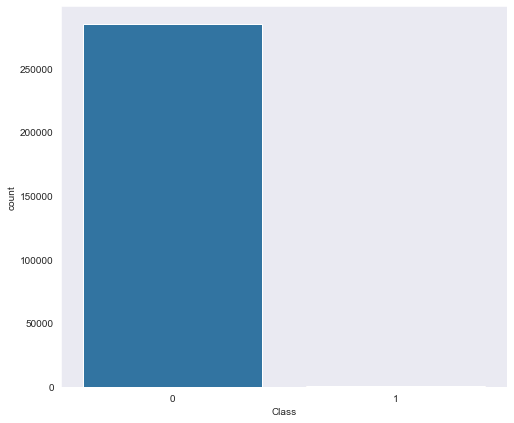

In [25]:
plt.figure(figsize=(8,7))
sns.countplot('Class', data=data)

Total positive cases of fraud: 492.

We see the data is highly unbalanced toward non fraudulent cases.

In [26]:
#define the features and target values
features = ['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount']

target = 'Class'

In [39]:
#plot a heatmap of the feature correlations
def plot_heat_map(data, features):
    plt.figure(figsize=(15,10))
    sns.heatmap(data[features].corr(), square=True, robust=True, annot=True, fmt='.2f')
    plt.yticks(rotation=0); 

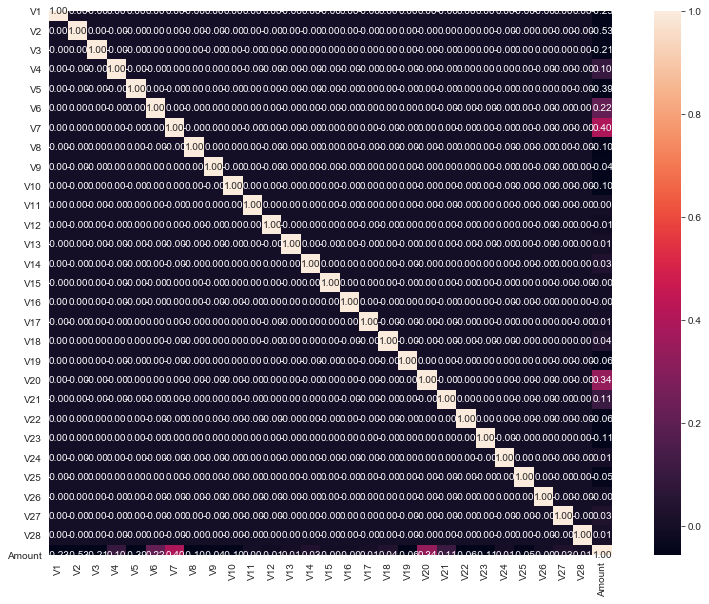

In [40]:
plot_heat_map(data, features)

A result of the imbalanced data, the correlations between features doesn't give us insight into the feature vectors with the strongest predictor values.

### Setup a simple classifier to test on the data

In [9]:
def get_train_test(data, features, target):
    #split the data into default train test splits
    X_train, X_test, Y_train, Y_test = train_test_split(data[features], data[target], train_size=0.7, random_state=99)

    return X_train, X_test, Y_train, Y_test

In [10]:
def simple_logistic_regressor(X_train, X_test, Y_train):

    #instantiate model. setting the solver (defailt) avoids warnings
    lr_base_model = LogisticRegression(solver='liblinear')

    kf = KFold(10, random_state=99)

    #fit the model
    lr_base_model.fit(X_train, Y_train)

    #get cross validated predictions
    lr_base_training = cross_val_predict(lr_base_model, X_train, Y_train, cv=kf)

    lr_base_test = lr_base_model.predict(X_test)
    
    return lr_base_training, lr_base_test

### Function to display classifier perofrmance metrics

Set a function to view metrics:


In [11]:
def display_metrics(Y_test, Y_preds, title='Baseline data without sampling applied'):
    
    cm = confusion_matrix(Y_test, Y_preds)
    
    tn, fp,fn,tp = cm.ravel()
    
    print(title)
    
    print('Summary of classifier performance with various metrics')
    print('\n')
    print('Confusion Matrix')
    print(cm)
    print('\n')
    print('Cassification report')
    print(classification_report(Y_test, Y_preds))


## Naive classification on imblanced data

In [18]:
#split the data
X_train, X_test, Y_train, Y_test = get_train_test(data, features, target)

#train model
lr_base_train, lr_base_test = simple_logistic_regressor(X_train, X_test, Y_train)

#display naive results
display_metrics(Y_test, lr_base_test)

Baseline data without sampling applied
Summary of classifier performance with various metrics


Confusion Matrix
[[85276    10]
 [   60    97]]


Cassification report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85286
           1       0.91      0.62      0.73       157

    accuracy                           1.00     85443
   macro avg       0.95      0.81      0.87     85443
weighted avg       1.00      1.00      1.00     85443



With an unbalanced dataset we see that accruacy is extremely high while the confusionmatrix actually indicates that our classifer is performing fairly poorly. Of the 492 cases of fraud in the data set we only succesfully classified 200.


#### Summary of each error metric

**Confusion matrix** - an array that identifies the number of true and false positives and negatives of the form:

|Sklearn Implementation||
|--------------|----------------|
|True Negative | False Positive |
|False Nagative | True Positive |

**Accuracy** - The overall effectiveness of the classifier. Caculated as TP+TN / (TP + TN + FP + FN)

**Precision** - Class agreement of the data labels with the class predictions of the classifier
Calcualted as TP / (TP + FP)

**Recall** (aka Sensitivity) - The effectiveness of a classifier to identify positive labels Calculated as TP / (TP + FN)

**F1 Score** - Combination of precision and senitivity in a single metric. Caculated as 2 * (precison * sensitivity) / (precision + sensitivity)



## Unbalanced dataset tecniques

As seen in the example above our data is highly unbalanced. Two techniques to overcome this are undersampling and oversampling.

### Classification with Undersampling

Undersampling is a method of sampling the overrepresented class so as to match the size of the unrerepresented sample.

In [15]:
#set the size of the random sample
small_sample_size = (data['Class']==1).sum()


#random sample from each of the two classes
class_0_sample = data[data['Class']==0].sample(n=small_sample_size, replace=False, random_state=99, axis=0)
class_1_sample = data[data['Class']==1].sample(n=small_sample_size, replace=False, random_state=99, axis=0)

#combine the two samples into one dataframe
undersample_data = pd.concat([class_0_sample, class_1_sample], axis = 0)

#randomly suffle the data before passing it to classifier
undersample_data = undersample_data.reindex(np.random.permutation(undersample_data.index))


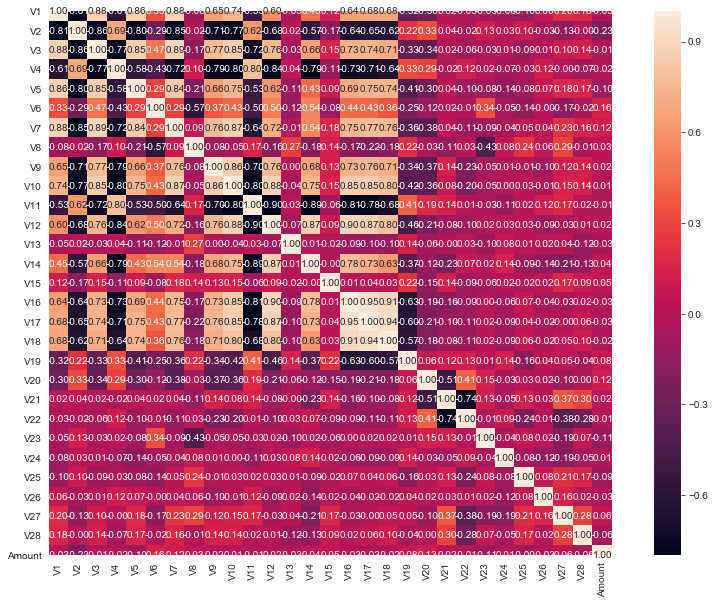

In [41]:
#plot a heat map of the undersampled data
plot_heat_map(undersample_data, features)

After redistributing the sample proportions the principle componentes are directly visible in the correlation heatmap.

In [21]:
#set up new train and test sets
X_train_under, X_test_under, Y_train_under, Y_test_under = get_train_test(undersample_data, features, target)

#train on the undersampled data
undersample_train, undersample_test = simple_logistic_regressor(X_train_under, X_test_under, Y_train_under)

#disply performance metrics
display_metrics(Y_test_under, undersample_test, title='Metrics after undersampling applied')

Metrics after undersampling applied
Summary of classifier performance with various metrics


Confusion Matrix
[[133   8]
 [ 12 143]]


Cassification report
              precision    recall  f1-score   support

           0       0.92      0.94      0.93       141
           1       0.95      0.92      0.93       155

    accuracy                           0.93       296
   macro avg       0.93      0.93      0.93       296
weighted avg       0.93      0.93      0.93       296



After undersampling the dominant class we can see the confusion matrix makes more sense. The accuracy metric has dropped while both recall and precision have increased. The latter two indicate that our simple classifier is doing a better job of identifying the true positives as a result of undersampling. 

### Oversampling
An alternative is to create samples in the underrepresented class by imputing new values. There are several methods that may be deployed.

Naive oversampling where the underrepresented sample is sampled with replacement from the available data. Consdiering how imbalnced this data is it does not seem like a good option (would need to oversample 400x to reach balance).

The library imbalnce-learn provides two methods for oversampling, SMOTE and ADASYN. This notebook will investigate using the SMOTE method.

#### Drawbacks to oversampling.
Oversampling is prone to magnification of bias because it generates new samples inferred from existing data points.

In [23]:
#oversample the original train and test sets
X_train_over, Y_train_over = SMOTE().fit_resample(X_train, Y_train)
X_test_over, Y_test_over = SMOTE().fit_resample(X_test, Y_test)

#train on the undersampled data
oversample_train, oversample_test = simple_logistic_regressor(X_train_over, X_test_over, Y_train_over)

#disply performance metrics
display_metrics(Y_test_over, oversample_test, title='Metrics after undersampling applied')

Metrics after undersampling applied
Summary of classifier performance with various metrics


Confusion Matrix
[[83661  1625]
 [ 4735 80551]]


Cassification report
              precision    recall  f1-score   support

           0       0.95      0.98      0.96     85286
           1       0.98      0.94      0.96     85286

    accuracy                           0.96    170572
   macro avg       0.96      0.96      0.96    170572
weighted avg       0.96      0.96      0.96    170572



The oversampling method has improved precision, recall and lowered accuracy. Similar results compared with the undersampling technique.

## Summary

1. Checking for imalance in a data set is a core inital step in developing a plan for modelling data.
2. With imbalanced data two methods of balancing exist, undersampling and oversampling. Undersampling is preferred and may be used when the sample size of the underrepresented sample is sufficent for modelling. In the case where the underreresented class is a small sample the options are to get more data, or try with oversampling. The choice of using oversampling will magnifiy any inherent bias in the model.
3. The error metrics precision and recall (sensitivitiy) can help discern an imbalnce is present if accruacy is extremly high and their respective values are low. i.e. accruavy = 0.99, precision, recall ~0.5
4. In imbalnced datasets correlations will not be visible because of the imbalnce. After applying over/undersample correlations and PCA can be applied to select features.